In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F

import os

from torchvision import datasets, transforms, models , utils
from torch.utils.data import random_split

In [ ]:
def to_device(data, device):
    "Move data to the device"
    if isinstance(data,(list,tuple)):
        return [to_device(x,device) for x in data]
    return data.to(device,non_blocking = True)

class DeviceDataLoader():
    """ Wrap a dataloader to move data to a device """
    
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
    
    def __iter__(self):
        """ Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b,self.device)
            
    def __len__(self):
        """ Number of batches """
        return len(self.dl)

In [ ]:
# Training class

class ImageClassificationBase(nn.Module):
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy

        return {'val_loss': loss.detach(), 'val_acc': acc}
        

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies

        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [ ]:
# Model training and evaluation

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

  
def fit(epochs, lr, model, train_loader, val_loader, opt_func):
    
    history = []
    # optimizer = opt_func(model.parameters(),lr, momentum = 0.5)
    optimizer = opt_func(model.parameters(),lr)
    for epoch in range(epochs):
        
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            print(loss)

            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        print(result['train_loss'])
        print(result)
        model.epoch_end(epoch, result)
        history.append(result)
        classes_check(val_loader, model)
    
    return history

def classes_check(val_batches, model):
    classes = ('cherry', 'strawberry', 'tomato')
    # prepare to count predictions for each class
    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}

    # again no gradients needed
    with torch.no_grad():
        for data in val_batches:
            images, labels = data
            outputs = model(images)
            _, predictions = torch.max(outputs, 1)
            # collect the correct predictions for each class
            for label, prediction in zip(labels, predictions):
                if label == prediction:
                    correct_pred[classes[label]] += 1
                total_pred[classes[label]] += 1

    # print accuracy for each class
    for classname, correct_count in correct_pred.items():
        accuracy = 100 * float(correct_count) / total_pred[classname]
        print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                             accuracy))

In [ ]:
# CNN model

class FruitClassification(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            torch.nn.Dropout(0,25),
            nn.Conv2d(3, 32, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(32,64, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Flatten(),
            nn.Linear(1440000,32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16,8),
            nn.ReLU(),
            nn.Linear(8,3)
        )
    
    def forward(self, xb):
        return self.network(xb)

In [ ]:
def plot_accuracies(history):
    """ Plot the history of accuracies"""
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');
    

def plot_losses(history):
    """ Plot the losses in each epoch"""
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');


In [ ]:
##############################
#                            #
#     Running Model          #
#                            #
##############################

In [ ]:
# Import training images from zipped folder in Colab directory
from google.colab import drive
drive.mount('/content/drive')

!unzip /content/traindata_augmented.zip

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Archive:  /content/traindata_augmented.zip
  inflating: traindata_augmented/.DS_Store  
   creating: traindata_augmented/cherry/
  inflating: traindata_augmented/cherry/.DS_Store  
  inflating: traindata_augmented/cherry/0_100.jpg  
  inflating: traindata_augmented/cherry/139_100.jpg  
  inflating: traindata_augmented/cherry/140_100.jpg  
  inflating: traindata_augmented/cherry/141_100.jpg  
  inflating: traindata_augmented/cherry/149_100.jpg  
  inflating: traindata_augmented/cherry/159_100.jpg  
  inflating: traindata_augmented/cherry/163_100.jpg  
  inflating: traindata_augmented/cherry/164_100.jpg  
  inflating: traindata_augmented/cherry/165_100.jpg  
  inflating: traindata_augmented/cherry/166_100.jpg  
  inflating: traindata_augmented/cherry/167_100.jpg  
  inflating: traindata_augmented/cherry/168_100.jpg  
  inflating: traindata_augmented/cherry/169_

In [ ]:
notebook_path = os.path.abspath("COMP309FinalProject.ipynb")
data_dir = os.path.join(os.path.dirname(notebook_path), "traindata_augmented")

dataset = datasets.ImageFolder(data_dir,transform = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(), 
    transforms.Normalize(0.5, 0.5, 0.5)
]))

In [ ]:
batch_size = 30
val_size = 500
train_size = len(dataset) - val_size

train_data,val_data = random_split(dataset,[train_size,val_size])
print(f"Length of Train Data : {len(train_data)}")
print(f"Length of Validation Data : {len(val_data)}")

train_dl = torch.utils.data.DataLoader(train_data, batch_size, shuffle = True)
val_dl = torch.utils.data.DataLoader(val_data, batch_size*2)

Length of Train Data : 4170
Length of Validation Data : 500


In [ ]:
# Load into the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

device

device(type='cuda', index=0)

In [ ]:
# Load model to the device
model = FruitClassification()
to_device(model, device)
model

FruitClassification(
  (network): Sequential(
    (0): Dropout(p=0, inplace=25)
    (1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): ReLU()
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=1440000, out_features=32, bias=True)
    (8): ReLU()
    (9): Linear(in_features=32, out_features=16, bias=True)
    (10): ReLU()
    (11): Linear(in_features=16, out_features=8, bias=True)
    (12): ReLU()
    (13): Linear(in_features=8, out_features=3, bias=True)
  )
)

In [ ]:
# Initial evaluation of the model
evaluate(model, val_dl)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


{'val_acc': 0.3296296298503876, 'val_loss': 1.1180462837219238}

In [ ]:
#set the no. of epochs, optimizer funtion and learning rate
num_epochs = 10
opt_func = torch.optim.SGD
lr = 0.01
# lr = 0.001
# lr = 0.0001

In [ ]:
#fitting the model on training data and record the result after each epoch
# history, accuracy_by_class = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

tensor(1.0996, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.1768, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.0690, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.1488, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.0697, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.0905, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.0548, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.0827, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.1392, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.0963, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.0980, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.1549, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.1595, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.1014, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.1397, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.1077, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.1176, device='cuda:0', grad_fn=<NllLossBackward

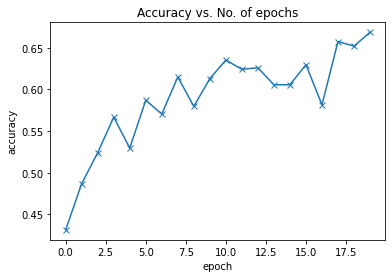

In [ ]:
plot_accuracies(history)



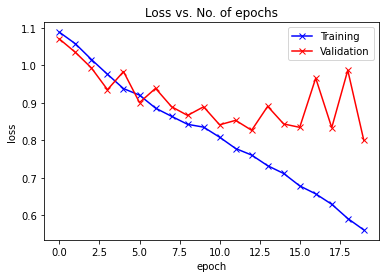

In [ ]:
plot_losses(history)